In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
tf.__version__

'2.9.2'

In [3]:
img_size = 400

(3056, 4592, 3)
(1, 400, 400, 3)


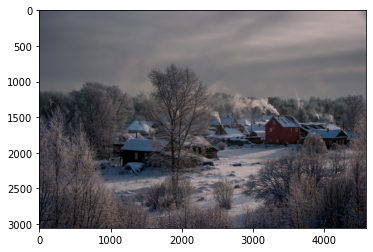

In [4]:

content_image = np.array(Image.open("/content/drive/MyDrive/Image 1.jpg"))

print(np.shape(content_image))
imshow(content_image)
# get image as array, then resize
content_image = Image.fromarray(content_image)
content_image =np.array(content_image.resize((img_size, img_size)))

# create content image as tf tensor
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
print(np.shape(content_image))



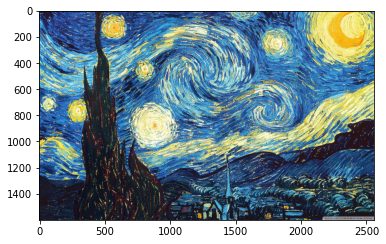

In [5]:
style_image = np.array(Image.open("/content/drive/MyDrive/Starry Night by Van Gogh.jpg"))
imshow(style_image)
style_image = Image.fromarray(style_image)
style_image = np.array(style_image.resize((img_size, img_size)))

style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))



In [6]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)


vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='/content/drive/MyDrive/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

In [7]:
STYLE_LAYERS = [
    ('block1_conv1', .2),
    ('block2_conv1', .2),
    ('block3_conv1', .2),
    ('block4_conv1', .2),
    ('block5_conv1', .2)]

In [8]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
       
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
    # compute the cost with tensorflow 
    J_content =  (1/(4*n_H*n_W*n_C) )*tf.reduce_sum(tf.square( tf.subtract(a_C_unrolled, a_G_unrolled ) ))
    
    
    
    return J_content

In [9]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    
    
    GA = tf.linalg.matmul(
    A, A, transpose_b=True)
    

    return GA

In [10]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) 
    a_S = tf.transpose(a_S)
    a_S=tf.reshape(a_S, shape=[n_C, n_H * n_W])
    a_G = tf.transpose(a_G)#, shape=[n_C, n_H * n_W])
    a_G=tf.reshape(a_G, shape=[n_C, n_H * n_W])
    
    print(np.shape(a_S))
    
    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computing the loss (≈1 line)
    J_style_layer = J_content =  (1/(4*(n_H*n_W)**2*n_C**2) )*tf.reduce_sum(tf.square( tf.subtract(GS, GG ) ))
    
    
    
    return J_style_layer

In [11]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not to be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the array contains the content layer image, which must not to be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [12]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content +beta*J_style
    
    
    return J

(1, 400, 400, 3)


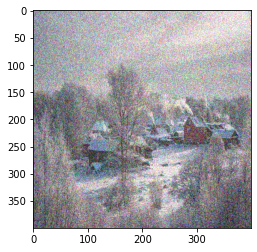

In [23]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
print(generated_image.shape)
imshow(generated_image[0])
plt.show()

In [14]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [15]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [16]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [17]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.0066939453, shape=(), dtype=float32)


In [18]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

(64, 160000)
(128, 40000)
(256, 10000)
(512, 2500)
(512, 625)
tf.Tensor(1206.3584, shape=(), dtype=float32)


In [19]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        

        a_G = vgg_model_outputs(generated_image)
        # Compute the style cost
     
        J_style = compute_style_cost(a_S, a_G)

        
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 20, beta = 30)  
        
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
  
    return J



(64, 160000)
(128, 40000)
(256, 10000)
(512, 2500)
(512, 625)
(64, 160000)
(128, 40000)
(256, 10000)
(512, 2500)
(512, 625)
Epoch 0 
Epoch 100 
Epoch 200 
Epoch 300 
Epoch 400 
Epoch 500 
Epoch 600 
Epoch 700 
Epoch 800 
Epoch 900 
Epoch 1000 
Epoch 1100 
Epoch 1200 
Epoch 1300 
Epoch 1400 
Epoch 1500 
Epoch 1600 
Epoch 1700 
Epoch 1800 
Epoch 1900 
Epoch 2000 
Epoch 2100 
Epoch 2200 
Epoch 2300 
Epoch 2400 
Epoch 2500 
Epoch 2600 
Epoch 2700 
Epoch 2800 
Epoch 2900 
Epoch 3000 


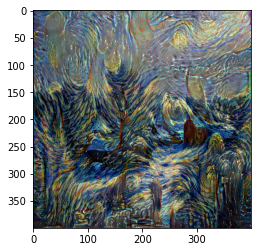

In [27]:
# Show the generated image at some epochs
# Uncoment to reset the style transfer process. You will need to compile the train_step function again 
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
epochs = 3001
for i in range(epochs):
    train_step(generated_image)
    if i % 100 == 0:
        print(f"Epoch {i} ")
    if i % 100 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"image_{i}.jpg")
         

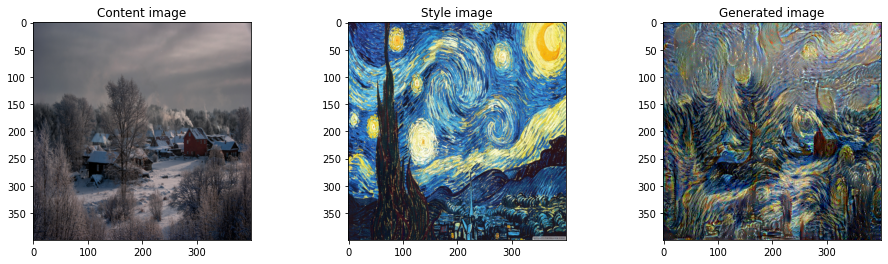

In [28]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()